### Data eploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd

# Exemple de données
df= pd.read_csv('./data_sorted.csv',sep=',')

In [16]:
df.head()

,F_SESSION,F_START_FRAME,F_END_FRAME,F_DURATION,FIRST_WORD_INDEX,SECOND_WORD_INDEX,THIRD_WORD_INDEX
0,3130311,332,375,00:00:22.000,3.0,10.0,285.0
1,3130311,376,441,00:00:33.000,3.0,76.0,281.0
2,3130311,442,741,00:02:30.000,3.0,10.0,8.0
3,3130311,742,760,00:00:09.500,3.0,28.0,40.0
4,3130311,761,764,00:00:02.000,3.0,10.0,8.0


In [17]:
df.describe()

,F_SESSION,F_START_FRAME,F_END_FRAME,FIRST_WORD_INDEX,SECOND_WORD_INDEX,THIRD_WORD_INDEX
count,2.468114e+06,2.468114e+06,2.468114e+06,2.468114e+06,2.468114e+06,2.468114e+06
mean,3.168152e+06,1.035792e+04,1.036893e+04,1.146257e+00,5.351101e+01,1.517446e+02
std,1.951907e+04,6.445171e+03,6.444702e+03,1.673727e+00,5.102162e+01,1.706293e+02
min,3.130311e+06,4.400000e+01,9.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.154750e+06,5.451000e+03,5.462000e+03,0.000000e+00,1.300000e+01,2.600000e+01
50%,3.169123e+06,9.133000e+03,9.142000e+03,1.000000e+00,3.700000e+01,8.700000e+01
75%,3.184073e+06,1.451100e+04,1.452300e+04,1.000000e+00,8.400000e+01,2.190000e+02
max,3.203720e+06,4.151000e+04,4.160000e+04,1.100000e+01,9.750000e+02,1.203000e+03


In [19]:
print("Nombre de vols :", df['F_SESSION'].nunique())

Nombre de vols : 1838


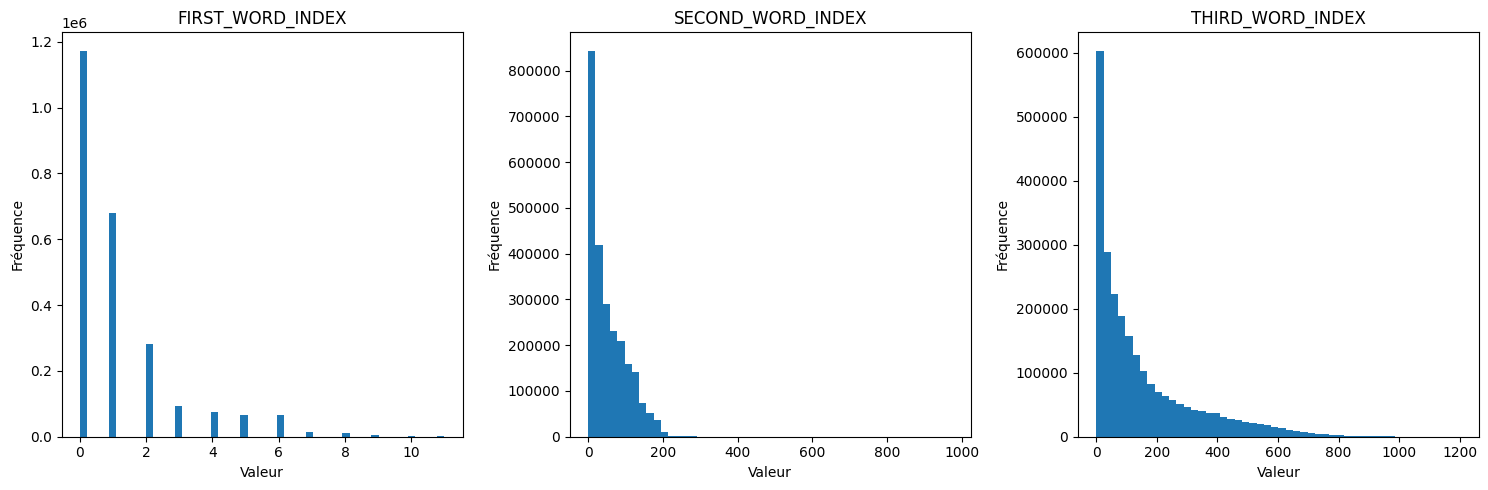

In [21]:
# Colonnes à tracer
cols = ['FIRST_WORD_INDEX', 'SECOND_WORD_INDEX', 'THIRD_WORD_INDEX']

# Créer la figure et les sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(cols):
    axes[i].hist(df[col].dropna(), bins=50)
    axes[i].set_title(col)
    axes[i].set_xlabel('Valeur')
    axes[i].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

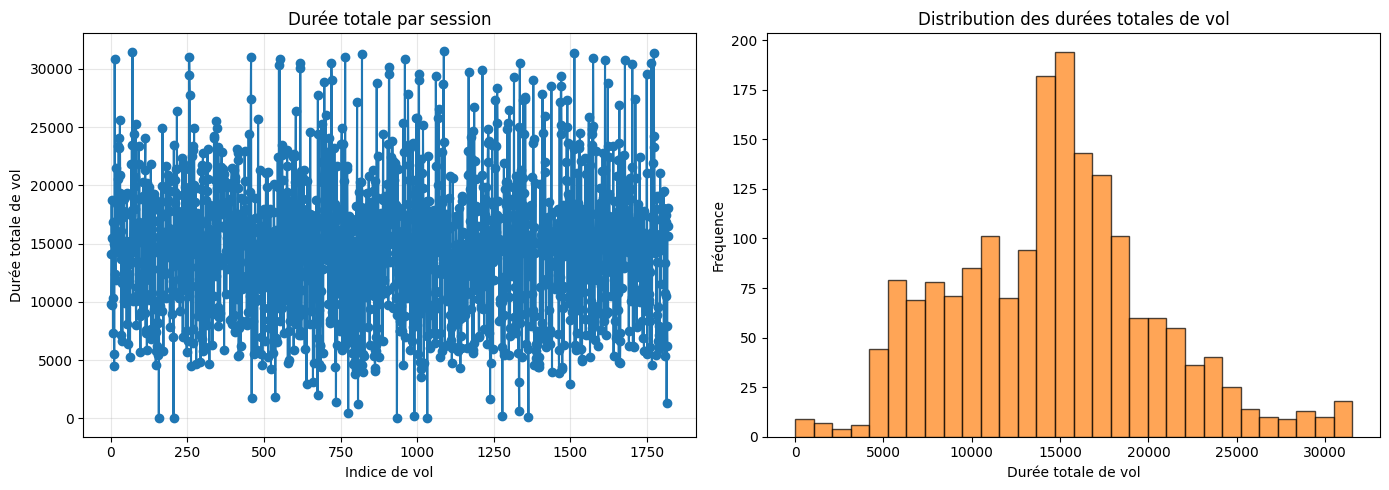

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Calcul de la durée par vol
df["F_DURATION"] = df["F_END_FRAME"] - df["F_START_FRAME"]

# Durée totale par session
session_duration = df.groupby('F_SESSION')['F_DURATION'].sum().reset_index()

# (Optionnel) Retirer les valeurs extrêmes pour un affichage plus clair
max_dur = np.percentile(session_duration["F_DURATION"], 99)
filtered = session_duration[session_duration["F_DURATION"] <= max_dur]

# Création des deux graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- 1️⃣ Durée totale par session ---
axes[0].plot(range(1, len(filtered) + 1), filtered['F_DURATION'], 
             marker='o', linewidth=1.5, color='tab:blue')
axes[0].set_xlabel('Indice de vol')
axes[0].set_ylabel('Durée totale de vol')
axes[0].set_title('Durée totale par session')
axes[0].grid(alpha=0.3)

# --- 2️⃣ Histogramme des durées totales par session ---
axes[1].hist(filtered['F_DURATION'], bins=30, color='tab:orange', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Durée totale de vol')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution des durées totales de vol')

plt.tight_layout()
plt.show()


## Embedding

In [ ]:
# Regrouper par vol
vols = df.groupby("F_SESSION").apply(
    lambda x: " ".join(map(str, x[["FIRST_WORD_INDEX","SECOND_WORD_INDEX","THIRD_WORD_INDEX"]].values.flatten()))
)

/tmp/ipykernel_1433/696387871.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vols = df.groupby("F_SESSION").apply(


In [3]:
# Embeddings
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(vols.tolist(), show_progress_bar=True)

# # Clustering
# kmeans = KMeans(n_clusters=10, random_state=0)
# labels = kmeans.fit_predict(embeddings)

# # Résultat
# result = pd.DataFrame({"vol": vols.index, "cluster": labels})
# print(result)

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

In [4]:
import numpy as np
import pandas as pd

# 1. Calculer les moyennes de F_START_FRAME et F_END_FRAME par vol
time_features = (
    df.groupby("F_SESSION")[["F_START_FRAME", "F_END_FRAME"]]
    .mean()
    .reset_index()
)

# 2. Calculer la différence entre fin et début
time_features["F_DURATION"] = time_features["F_END_FRAME"] - time_features["F_START_FRAME"]

# 3. Combiner avec les embeddings texte
# ⚠️ Il faut que les embeddings soient alignés sur les mêmes F_SESSION
# Par exemple, si embeddings est dans l’ordre de df['F_SESSION'].unique()
embeddings_aligned = embeddings  # à adapter selon ton cas

# Extraire les colonnes numériques (F_START_FRAME, F_END_FRAME, F_DURATION)
time_values = time_features[["F_START_FRAME", "F_END_FRAME", "F_DURATION"]].values

# 4. Combiner horizontalement
combined_embeddings = np.hstack([embeddings_aligned, time_values])

# 5. Vérification
print("Shape des embeddings combinés :", combined_embeddings.shape)


Shape des embeddings combinés : (1838, 771)


## Clustering

/home/mohamed/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mohamed/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


--- HDBSCAN ---
Nombre de clusters trouvés : 46
Points considérés comme bruit : 381
--- DBSCAN ---
Nombre de clusters trouvés : 1
Points considérés comme bruit : 4
--- KMeans ---
Nombre de clusters trouvés : 5
Points considérés comme bruit : 0


/tmp/ipykernel_1433/309929447.py:94: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


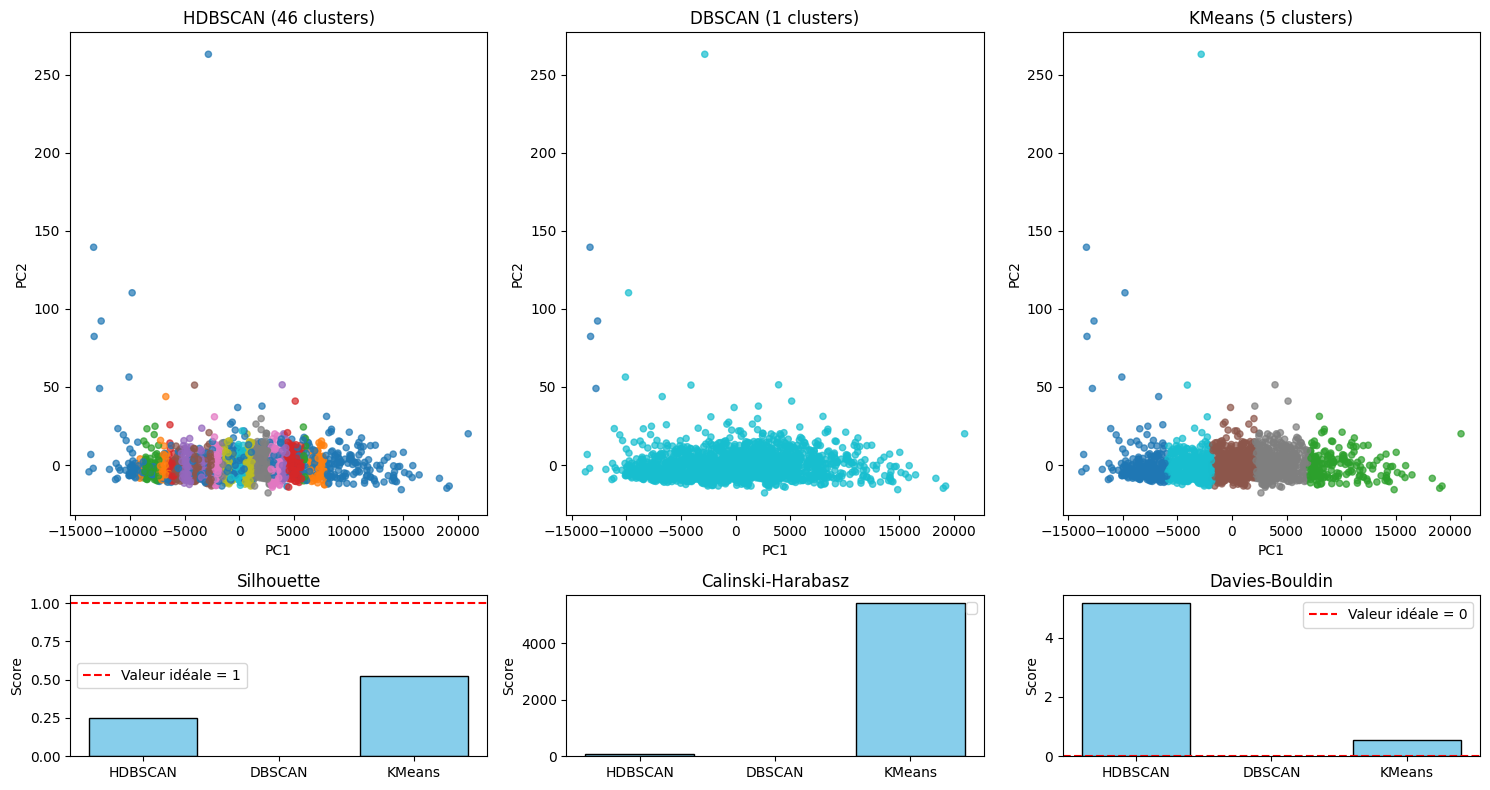

In [36]:
# --- Installation (si besoin) ---
# !pip install hdbscan scikit-learn matplotlib numpy pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

# ======================================================
#  Étape 1 : Données (tes embeddings combinés)
# ======================================================
# combined_embeddings = np.hstack([embeddings, time_features])
# Exemple de données factices :
# combined_embeddings = np.random.rand(500, 20)

# ======================================================
#  Étape 2 : Définir les algorithmes
# ======================================================
clusterers = {
    "HDBSCAN": hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean'),
    "DBSCAN": DBSCAN(eps=1e-4, min_samples=5, metric='cosine'),
    "KMeans": KMeans(n_clusters=5, random_state=42)
}

# Pour stocker les résultats
results = {}

# ======================================================
#  Étape 3 : Entraîner et évaluer
# ======================================================
for name, clusterer in clusterers.items():
    labels = clusterer.fit_predict(combined_embeddings)
    n_clusters = len(np.unique(labels[labels >= 0]))
    n_noise = np.sum(labels == -1) if -1 in labels else 0

    print(f"--- {name} ---")
    print(f"Nombre de clusters trouvés : {n_clusters}")
    print(f"Points considérés comme bruit : {n_noise}")

    # Scores uniquement si au moins 2 clusters
    if n_clusters > 1:
        sil = silhouette_score(combined_embeddings, labels)
        ch = calinski_harabasz_score(combined_embeddings, labels)
        db = davies_bouldin_score(combined_embeddings, labels)
    else:
        sil, ch, db = np.nan, np.nan, np.nan

    results[name] = {
        "labels": labels,
        "n_clusters": n_clusters,
        "n_noise": n_noise,
        "Silhouette": sil,
        "Calinski-Harabasz": ch,
        "Davies-Bouldin": db
    }

# ======================================================
#  Étape 4 : PCA pour visualisation
# ======================================================
pca = PCA(n_components=2)
points_2d = pca.fit_transform(combined_embeddings)

fig, axes = plt.subplots(2, 3, figsize=(15, 8), gridspec_kw={'height_ratios': [3, 1]})
axes = axes.flatten()

# ---- Ligne du haut : visualisation des clusters ----
for i, (name, res) in enumerate(results.items()):
    ax = axes[i]
    ax.scatter(points_2d[:, 0], points_2d[:, 1],
               c=res["labels"], cmap='tab10', s=20, alpha=0.7)
    ax.set_title(f"{name} ({res['n_clusters']} clusters)")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

# ---- Ligne du bas : métriques ----
metrics = ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]
ideal_values = {"Silhouette": 1, "Calinski-Harabasz": "haut", "Davies-Bouldin": 0}

for j, metric in enumerate(metrics):
    ax = axes[3 + j]
    values = [results[m][metric] for m in clusterers.keys()]
    ax.bar(clusterers.keys(), values, color="skyblue", edgecolor="black")
    ax.set_title(metric)

    # Ligne rouge pour valeur idéale
    if metric == "Silhouette":
        ax.axhline(1, color='red', linestyle='--', label='Valeur idéale = 1')
    elif metric == "Davies-Bouldin":
        ax.axhline(0, color='red', linestyle='--', label='Valeur idéale = 0')

    ax.legend()
    ax.set_ylabel("Score")

plt.tight_layout()
plt.show()


In [15]:
print(combined_embeddings.shape)

(1838, 771)
